In [2]:
#-----------------------------------
# GLOBAL FEATURE EXTRACTION
#-----------------------------------
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import mahotas
import cv2
import os
import h5py

#--------------------
# tunable-parameters
#--------------------
images_per_class       = 800
fixed_size             = tuple((500, 500))
train_path             = "dataset/train"
bins                   = 8


In [3]:
# Converting each image to RGB from BGR format

def rgb_bgr(image):
    rgb_img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return rgb_img


In [4]:
# Conversion to HSV image format from RGB

def bgr_hsv(rgb_img):
    hsv_img = cv2.cvtColor(rgb_img, cv2.COLOR_RGB2HSV)
    return hsv_img

In [5]:
# image segmentation

# for extraction of green and brown color

def img_segmentation(img):
    ####slic segmentation
#     from skimage import segmentation
#     import numpy as np
#     import cv2
#     from skimage import morphology
#     from matplotlib import pyplot as plt
#     from skimage.segmentation import mark_boundaries
# #     image=cv2.imread('Plant-Disease-Detection/image.jpg')
#     image = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
# #     rgb_img=cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#     # print(mask.shape)
#     segments = segmentation.slic(image, compactness=1, n_segments=3)
#     #seg_img=np.zeros((256,256,3))
#     region2=segments==2
#     region0=segments==0
#     region1=segments==1
#     region3=segments==3
# #     print(region1)

 
#     for i in range(0,256):
#         for j in range (0,256):
#             if region0[i][j]==True:
#                 image[i][j][0]=0
#                 image[i][j][1]=0
#                 image[i][j][2]=0
#     for i in range(0,256):
#         for j in range (0,256):
#             if region1[i][j]==True:
#                 image[i][j][0]=0
#                 image[i][j][1]=0
#                 image[i][j][2]=0
#     seg_img=image
#     seg_img=cv2.cvtColor(seg_img, cv2.COLOR_LAB2RGB)
#     for i in range(0,256):
#          for j in range (0,256):
#                   if seg_img[i][j][0]==0 and seg_img[i][j][1]==64 and seg_img[i][j][2]==194:
#                         seg_img[i][j][0]=0
#                         seg_img[i][j][1]=0
#                         seg_img[i][j][2]=0

#######working code for mask segmentation 
    rgb_img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    lab_img=cv2.cvtColor(rgb_img,cv2.COLOR_RGB2LAB)
    g_m=cv2.inRange(lab_img,np.array([0,130,0]),np.array([250,255,255]))
    g_m=~g_m
    d_m=cv2.inRange(lab_img,np.array([0,130,135]),np.array([255,255,235]))
    d_m=d_m
    f_m=d_m+g_m
    seg_img=cv2.bitwise_and(rgb_img,rgb_img,mask=f_m)
######end working code   
    return seg_img


In [6]:

def fd_hu_moments(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    feature = cv2.HuMoments(cv2.moments(image)).flatten()
    return feature

In [7]:

def fd_haralick(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    haralick = mahotas.features.haralick(gray).mean(axis=0)
    return haralick

In [8]:
def fd_histogram(image, mask=None):
# image=cv2.imread('dataset/train/healthy/1.jpg')
        image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        hist  = cv2.calcHist([image], [0, 1, 2], None, [bins, bins, bins], [0, 256, 0, 256, 0, 256])
        cv2.normalize(hist, hist)
        return hist.flatten()

In [9]:
 def fd_color(image):
    import mahotas
    import cv2
    import numpy as np
    from skimage.feature.texture import greycomatrix
    test_hsv=cv2.cvtColor(image,cv2.COLOR_BGR2HSV)

    h,s,v=test_hsv[:,:,0],test_hsv[:,:,1],test_hsv[:,:,2]

##h,s mean and std_dev
    h_mean,h_std=cv2.meanStdDev(h)
    s_mean,s_std=cv2.meanStdDev(s)
    color_fea=np.array([h_mean,h_std,s_mean,s_std])
#     print(h_mean,h_std,s_mean,s_std)
    haralick_fea = mahotas.features.haralick(v).mean(axis=0)
    color_fea=np.append(color_fea,haralick_fea)
    return color_fea


In [11]:
# get the training labels
train_labels = os.listdir(train_path)

# sort the training labels
train_labels.sort()
print(train_labels)

# empty lists to hold feature vectors and labels
global_features = []
labels          = []

images_class={}
ctr=0
###counting images in each class i.e healthy or disease
for c in train_labels:

    path="dataset/train/"+c
    images_class[c]=len(os.listdir(path))
    
   

print(images_class)

['diseased', 'healthy']
{'diseased': 805, 'healthy': 904}


In [12]:

ptr=1
# data=pd.dataframe()
for training_name in train_labels:
    # join the training data path and each species training folder
    dir = os.path.join(train_path, training_name)

    
    current_label = training_name
    if(ptr==1):
        images_per_class=805
    else:
        images_per_class=904
   
    for x in range(1,images_per_class+1):
        
        file = dir + "/" + str(x) + ".jpg"

       
        image = cv2.imread(file)
        image = cv2.resize(image, fixed_size)

        
       
        
        RGB_BGR       = rgb_bgr(image)
        BGR_HSV       = bgr_hsv(RGB_BGR)
#         IMG_SEGMENT   = img_segmentation(RGB_BGR,BGR_HSV)
        IMG_SEGMENT   = img_segmentation(image)

       
        
        fv_hu_moments = fd_hu_moments(IMG_SEGMENT)
        fv_haralick   = fd_haralick(IMG_SEGMENT)
        fv_histogram  = fd_histogram(IMG_SEGMENT)
        fv_color_fea=   fd_color(IMG_SEGMENT)
       
#       fv_gabor      = fd_gabor(IMG_SEGMENT)
       
        global_feature = np.hstack([fv_histogram, fv_haralick, fv_hu_moments,fv_color_fea])
        
        

        # update the list of labels and feature vectors
        labels.append(current_label)
        global_features.append(global_feature)

    print("[STATUS] processed folder: {}".format(current_label))
    ptr+=1
#     print(fv_color_fea)
#     print(len(fv_histogram) )
print("[STATUS] completed Global Feature Extraction...")

[STATUS] processed folder: diseased
[STATUS] processed folder: healthy
[STATUS] completed Global Feature Extraction...


In [13]:
# get the overall feature vector size
print("[STATUS] feature vector size {}".format(np.array(global_features).shape))

[STATUS] feature vector size (1709, 549)


In [14]:
# get the overall training label size
print("[STATUS] training Labels {}".format(np.array(labels).shape))

[STATUS] training Labels (1709,)


In [15]:
le          = LabelEncoder()
target      = le.fit_transform(labels)
print("[STATUS] training labels encoded...",target)

[STATUS] training labels encoded... [0 0 0 ... 1 1 1]


In [16]:
# scale features in the range (0-1)
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
scaler= MinMaxScaler(feature_range=(0, 1))
rescaled_features=scaler.fit_transform(global_features)
# data=pd.DataFrame(rescaled_features,columns=[np.arange(0,532,1)])
data=pd.DataFrame(rescaled_features)
# target=labels;
data["target"]=target
print(data)
# data.to_csv('mask_seg_features.csv')
data.to_csv('slic_seg_features.csv')
# print(rescaled_features.shape)
# print("[STATUS] feature vector normalized...")
# plt.scatter(rescaled_features[0],rescaled_features[531],color="blue",marker='*')

             0         1         2         3         4         5         6  \
0     0.894061  0.005173  0.010525  0.003791  0.003367  0.018329  0.003624   
1     0.957039  0.000202  0.000000  0.000000  0.000011  0.000070  0.000026   
2     0.953089  0.003803  0.004365  0.001308  0.002463  0.005261  0.000894   
3     0.984166  0.001427  0.000258  0.000023  0.000029  0.000925  0.007020   
4     0.888176  0.021568  0.017495  0.012346  0.004829  0.000754  0.000000   
...        ...       ...       ...       ...       ...       ...       ...   
1704  0.159796  0.011045  0.234252  0.698508  0.996362  0.022154  0.000000   
1705  0.989840  0.000328  0.004026  0.002538  0.002447  0.007634  0.014393   
1706  0.988662  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
1707  0.978036  0.000000  0.015149  0.019883  0.017201  0.008533  0.001401   
1708  0.983587  0.001480  0.000594  0.000170  0.000313  0.005539  0.001005   

             7         8         9  ...       540       541    

In [17]:
print("[STATUS] target labels: {}".format(target))
print("[STATUS] target labels shape: {}".format(len(labels)))

[STATUS] target labels: [0 0 0 ... 1 1 1]
[STATUS] target labels shape: 1709


In [18]:
# training
# -----------------------------------
# TRAINING OUR MODEL
# -----------------------------------
import h5py
import numpy as np
import os
import glob
import cv2
import warnings
from matplotlib import pyplot
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
#from sklearn.externals import joblib
import joblib
warnings.filterwarnings('ignore')

#--------------------
# tunable-parameters
#--------------------
num_trees = 100
test_size = 0.20
seed      = 9
train_path = "dataset/train"

# get the training labels
train_labels = os.listdir(train_path)

# sort the training labels
train_labels.sort()


global_features_string = np.array(rescaled_features)
global_labels_string   = np.array(target)
global_features = np.array(global_features_string)
global_labels   = np.array(global_labels_string)
# print(global_labels)
# h5f_data.close()
# h5f_label.close()




Accuracy 86.8421052631579%
[[117  40]
 [  5 180]]
[STATUS] splitted train and test data...
Train data  : (1367, 549)
Test data   : (342, 549)
Precision=TP/TP+FP: 95.90163934426229 %
Sensitivity=TP/TP+FN: 74.52229299363057 %
Specificity=TN/TN+FP: 97.29729729729729 %
F1-Score: 83.87096774193547 %


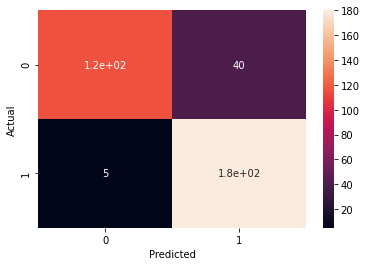

In [19]:
# split the training and testing data

import pandas as pd
import numpy
(trainDataGlobal, testDataGlobal, trainLabelsGlobal, testLabelsGlobal) = train_test_split(np.array(global_features),
                                                                                          np.array(global_labels),
                                                                                          test_size=test_size,random_state=seed)
clf_gauss=GaussianNB()
clf_gauss.fit(trainDataGlobal,trainLabelsGlobal)
NB_pr=clf_gauss.predict(testDataGlobal)
acc_NB = clf_gauss.score(testDataGlobal,testLabelsGlobal)
print('Accuracy',str(acc_NB*100)+"%")
cm=confusion_matrix(testLabelsGlobal,NB_pr)
print(cm)
Precision_NB=(cm[0][0])*100/(cm[0][0]+cm[1][0])
Sensitivity_NB=(cm[0][0])*100/(cm[0][0]+cm[0][1])
Specificity_NB=(cm[1][1])*100/(cm[1][1]+cm[1][0])
import seaborn as sm
sm.heatmap(cm,annot=True)
plt.xlabel('Predicted')
plt.ylabel('Actual')
print("[STATUS] splitted train and test data...")
print("Train data  : {}".format(trainDataGlobal.shape))
print("Test data   : {}".format(testDataGlobal.shape)) 
print("Precision=TP/TP+FP:",(cm[0][0])*100/(cm[0][0]+cm[1][0]),'%')
print("Sensitivity=TP/TP+FN:",(cm[0][0])*100/(cm[0][0]+cm[0][1]),'%')
print("Specificity=TN/TN+FP:",(cm[1][1])*100/(cm[1][1]+cm[1][0]),'%')
f_NB=2*(Precision_NB*Sensitivity_NB)/(Precision_NB+Sensitivity_NB)
print("F1-Score:",f_NB,'%')





Accuracy: 93.85964912280701%
[[149   8]
 [ 13 172]]
Precision=TP/TP+FP: 91.9753086419753 %
Sensitivity=TP/TP+FN: 94.90445859872611 %
Specificity=TN/TN+FP: 92.97297297297297 %
F1-Score: 93.41692789968651 %


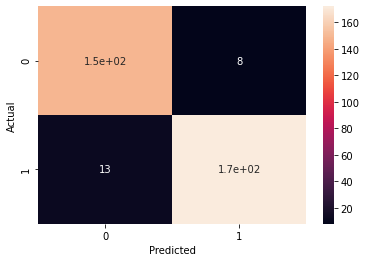

In [20]:
import pandas as pd
import numpy
from sklearn.svm import SVC
# clf = SVC(c=1,gamma=10)
clf=SVC(random_state=9)
#### now your job is to fit the classifier
clf.fit(trainDataGlobal, trainLabelsGlobal)
#### using the training features/labels, and to
#### make a set of predictions on the test data
pred=clf.predict(testDataGlobal)
#### store your predictions in a list named pred
from sklearn.metrics import accuracy_score,confusion_matrix
acc_svm = accuracy_score(pred, testLabelsGlobal)
print('Accuracy:',str(acc_svm*100)+"%")
cm=confusion_matrix(testLabelsGlobal,pred)

print(cm)
Precision_svm=(cm[0][0])*100/(cm[0][0]+cm[1][0])
Sensitivity_svm=(cm[0][0])*100/(cm[0][0]+cm[0][1])
Specificity_svm=(cm[1][1])*100/(cm[1][1]+cm[1][0])
import seaborn as sm
sm.heatmap(cm,annot=True)
plt.xlabel('Predicted')
plt.ylabel('Actual')
print("Precision=TP/TP+FP:",(cm[0][0])*100/(cm[0][0]+cm[1][0]),'%')
print("Sensitivity=TP/TP+FN:",(cm[0][0])*100/(cm[0][0]+cm[0][1]),'%')
print("Specificity=TN/TN+FP:",(cm[1][1])*100/(cm[1][1]+cm[1][0]),'%')
f_svm=2*(Precision_svm*Sensitivity_svm)/(Precision_svm+Sensitivity_svm)
print("F1-Score:",f_svm,'%')


plt.show()


Accuracy: 97.36842105263158%
[[153   4]
 [  5 180]]
Precision=TP/TP+FP: 96.83544303797468 %
Sensitivity=TP/TP+FN: 97.45222929936305 %
Specificity=TN/TN+FP: 97.29729729729729 %
F1-Score: 97.14285714285715 %
Feature 0:0.001537632349282282
Feature 1:0.0010980333540268883
Feature 2:0.0009870862139536576
Feature 3:0.0014765403346021656
Feature 4:0.004385689831175934
Feature 5:0.004892277082263677
Feature 6:0.006925736259397981
Feature 7:0.0009328593668311928
Feature 8:0.0015717341566563279
Feature 9:0.0009035426569530931
Feature 10:0.0016139006674133253
Feature 11:0.0030433375452183714
Feature 12:0.0013439126408382547
Feature 13:0.0034965843033152306
Feature 14:0.00237506536149781
Feature 15:0.0004020198773444572
Feature 16:0.0019164599461882407
Feature 17:0.0006024390238780185
Feature 18:0.001402461222189454
Feature 19:0.0014801962978890795
Feature 20:0.0008413098362603593
Feature 21:0.0004491828820439577
Feature 22:0.00043662574139407157
Feature 23:3.313701807036927e-06
Feature 24:0.00139

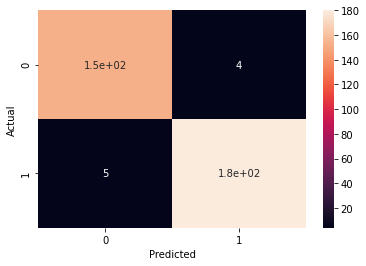

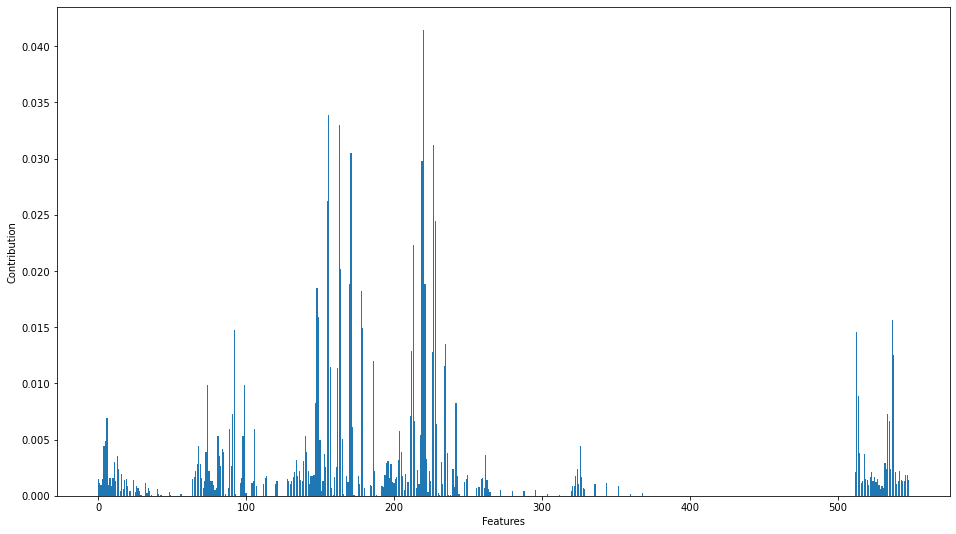

In [22]:
from sklearn.ensemble import  RandomForestClassifier
from sklearn.metrics import accuracy_score
import pandas as pd
import numpy
clf=RandomForestClassifier(n_estimators=1000,criterion='entropy',random_state=0)
clf.fit(trainDataGlobal,trainLabelsGlobal)
pred=clf.predict(testDataGlobal)
acc_rf=accuracy_score(pred,testLabelsGlobal)
print("Accuracy:",str(acc_rf*100)+"%");
cm=confusion_matrix(testLabelsGlobal,pred)

print(cm)
Precision_rf=(cm[0][0])*100/(cm[0][0]+cm[1][0])
Sensitivity_rf=(cm[0][0])*100/(cm[0][0]+cm[0][1])
Specificity_rf=(cm[1][1])*100/(cm[1][1]+cm[1][0])
import seaborn as sm
sm.heatmap(cm,annot=True)
plt.xlabel('Predicted')
plt.ylabel('Actual')
print("Precision=TP/TP+FP:",(cm[0][0])*100/(cm[0][0]+cm[1][0]),'%')
print("Sensitivity=TP/TP+FN:",(cm[0][0])*100/(cm[0][0]+cm[0][1]),'%')
print("Specificity=TN/TN+FP:",(cm[1][1])*100/(cm[1][1]+cm[1][0]),'%')
f_rf=2*(Precision_rf*Sensitivity_rf)/(Precision_rf+Sensitivity_rf)
print("F1-Score:",f_rf,'%')

# print(importances)
importances=clf.feature_importances_
for x in range (0,len(importances)):
    print("Feature {}:{}".format(x,importances[x]))
plt.subplots(figsize =(16,9))   
plt.bar(np.arange(0,549),importances)
plt.xlabel('Features')
plt.ylabel('Contribution')
plt.show()
# imp_df=pd.DataFrame({"features"=data.columns,"Importances":importance})
# imp_df.set_index('Importances')


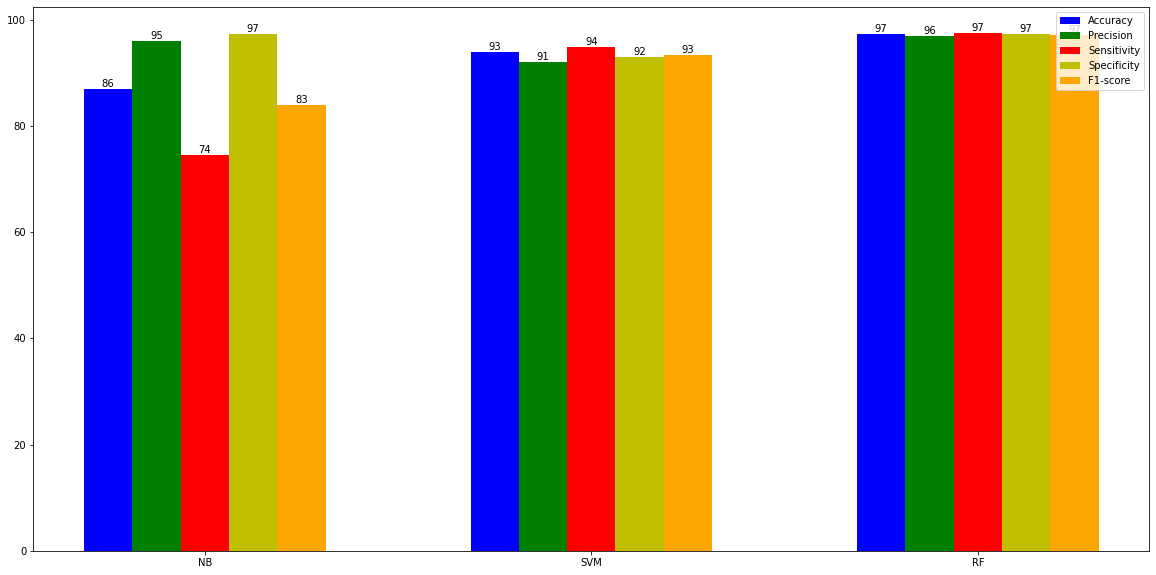

In [23]:
# import pyplot as plt
# plt.subplot(2,2,0)
import matplotlib.pyplot as plt
graph_data = [[acc_NB*100,acc_svm*100,acc_rf*100],
[Precision_NB,Precision_svm,Precision_rf],
[Sensitivity_NB,Sensitivity_svm,Sensitivity_rf],
[Specificity_NB,Specificity_svm,Specificity_rf],
              [f_NB,f_svm,f_rf]
]
X = np.arange(3)
fig,ax = plt.subplots()
fig.set_figheight(10)
fig.set_figwidth(20)
# ax = fig.add_axes([0,0,1,1])
rects1=ax.bar(X-0.250 , graph_data[0], color = 'b', width = 0.125,label='Accuracy')
rects2=ax.bar(X-.125, graph_data[1], color = 'g', width = 0.125,label='Precision')
rects3=ax.bar(X , graph_data[2], color = 'r', width = 0.125,label='Sensitivity')
rects4=ax.bar(X + 0.125, graph_data[3], color = 'y', width = 0.125,label='Specificity')
rects5=ax.bar(X + 0.250, graph_data[4], color = 'orange', width = 0.125,label='F1-score')
ax.set_xticks([0,1,2])
ax.set_xticklabels(["NB","SVM","RF"])
ax.legend()
def autolabel(rects):
    
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1*height,
                '%d' % int(height),
                ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)
autolabel(rects4)
autolabel(rects5)



plt.show()


In [24]:
##performance Analysis in tabular form
import pandas as pd
p_data = [["Gaussian Naive Bayes",acc_NB*100,Precision_NB,Sensitivity_NB,Specificity_NB,f_NB],
          ["Support Vector Machine",acc_svm*100,Precision_svm,Sensitivity_svm,Specificity_svm,f_svm],
          ["Random Forest",acc_rf*100,Precision_rf,Sensitivity_rf,Specificity_rf,f_rf]
]
perf_data=pd.DataFrame(p_data,columns=["Algo used","Accuracy(%)","Precision(%)","Sensitivity(%)","Specificity(%)","F1_score(%)"])
print(perf_data)

                Algo used  Accuracy(%)  Precision(%)  Sensitivity(%)  \
0    Gaussian Naive Bayes    86.842105     95.901639       74.522293   
1  Support Vector Machine    93.859649     91.975309       94.904459   
2           Random Forest    97.368421     96.835443       97.452229   

   Specificity(%)  F1_score(%)  
0       97.297297    83.870968  
1       92.972973    93.416928  
2       97.297297    97.142857  
